In [41]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop
from keras.layers import BatchNormalization
from keras.layers import Dropout
import tensorflow as tf

from sklearn.decomposition import PCA
from modules.pca_module import perform_pca
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


Once we have optimized the model, as the differences between the different dataframes (created by using different NaN imputation, usin or not PCA, and different balancing techniques) we will run the whole of them in the new NN model optimized.

### 1-Load data

In [42]:
knn_df = pd.read_csv('clean_data/withsetc/KNN_imputed_df.csv')
m1_df = pd.read_csv('clean_data/withsetc/minus1_imputed_df.csv')

### 2-IN_HOSPITAL_DEATH PREDICTION

**3.1 -Create a function that**
 - remove the outcome columns and palaces RecordID as index
 - splits the data
 - normalizes the data
 - creates / compiles and trains a basic model
 - predicts the outcomes


*OPTIMIZED FUNCTION PARAMETERS*
 - optimizer = SGD
 - hidden layers = 2
 - batch size = 16
 - units = 28
 - epochs = 40
 - learning rate = 0.1
 - dropout rate: 0.3

*Optimization and cost for the model*
- loss - binary_crossentropy
- metrics - "accurancy"  

We will run each df 10 times to evaluate the dispersion of the results
In order to keep all the results we will save them in a df

In [43]:
# Create a df to save the results
data = {
    "Model": 'NN_opt',
    "Method": [],
    "mean_precision": [],
    "mean_recall": [],
    "stdev_precision": [],
    "stdev_recall": []
}

df_opt_results = pd.DataFrame(data)


In [44]:
def run_function_10_times(df, function):
        precision = []
        recall = []
        for i in range(10):   
                y_test, y_pred = function(df)
                prec= precision_score(y_test, y_pred)
                rec = recall_score(y_test, y_pred)
                precision.append(prec)
                recall.append(rec)
        return np.mean(precision), np.mean(recall), np.std(precision), np.std(recall)

In [45]:
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,...,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
6095,148009.0,69.0,1,2,22.606103,1,7.0,14.285714,0.367089,0.5,...,180.0,-0.369037,6.1,13.934426,0.04848,63.5,0.0,0.033582,4,0


In [46]:
def NN_opt_model(df):
    """
    Builds and trains a basic neural network model for binary classification.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target variable.

    Returns:
        float: F1-score on the test set.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
 
    precision = precision_score(y_test, y_pred_binary)
    print(f"precision on test set: {precision:.2f}")
    recall = recall_score(y_test, y_pred_binary)
    print(f"recall on test set: {recall:.2f}")

    return y_test, y_pred_binary

**3.2- Evaluation of the model performance on the two loaded dataframes**

in order to have more information we will run each model 10 times

In [47]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_opt_model)

Epoch 1/40
600/600 [==============================] - 2s 2ms/step - loss: 0.3786 - accuracy: 0.8540
Epoch 2/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3366 - accuracy: 0.8616
Epoch 3/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3268 - accuracy: 0.8636
Epoch 4/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3169 - accuracy: 0.8660
Epoch 5/40
600/600 [==============================] - 2s 3ms/step - loss: 0.3130 - accuracy: 0.8673
Epoch 6/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3135 - accuracy: 0.8684
Epoch 7/40
600/600 [==============================] - 2s 3ms/step - loss: 0.3094 - accuracy: 0.8671
Epoch 8/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3032 - accuracy: 0.8714
Epoch 9/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.8715
Epoch 10/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3005 - accuracy: 0.8710

In [ ]:
print(f"basic_NN for Knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "knn_df"
df_opt_results.loc[0] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN for Knn_df : mean_prec = 0.5605035380217787, mean_rec =  0.3081570996978852, stdev_prec = 0.027549183892168986, stdev_recall = 0.051377285001767525


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377


In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_opt_model)

Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3664 - accuracy: 0.8526
Epoch 2/40
600/600 [==============================] - 1s 861us/step - loss: 0.3298 - accuracy: 0.8662
Epoch 3/40
600/600 [==============================] - 1s 860us/step - loss: 0.3205 - accuracy: 0.8673
Epoch 4/40
600/600 [==============================] - 1s 836us/step - loss: 0.3154 - accuracy: 0.8678
Epoch 5/40
600/600 [==============================] - 1s 843us/step - loss: 0.3125 - accuracy: 0.8701
Epoch 6/40
600/600 [==============================] - 1s 849us/step - loss: 0.3095 - accuracy: 0.8676
Epoch 7/40
600/600 [==============================] - 1s 842us/step - loss: 0.3081 - accuracy: 0.8730
Epoch 8/40
600/600 [==============================] - 1s 841us/step - loss: 0.3060 - accuracy: 0.8742
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3014 - accuracy: 0.8708
Epoch 10/40
600/600 [==============================] - 1s 846us/step - loss: 0.3002 - 

In [ ]:
print(f"basic_NN for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "m1_df"
df_opt_results.loc[1] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN for m1_df : mean_prec = 0.5387447746255986, mean_rec =  0.3429003021148036, stdev_prec = 0.028826805810036594, stdev_recall = 0.057134853865059995


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135


**3.3 -Use PCA in the models to check for improvement.**

As PCA already requieres standarization of numerica features a new function must be created but the model will be the same. 

In [ ]:
def NN_PCA_opt_model(df):
    """
    Builds and trains an improved neural network model for binary classification using PCA.

    Args:
        Data frame.

    Returns:
        Predicted value and real test value.
    """
        # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    #exclude categorical features from PCA transformation
    categorical_features = ['Gender', 'ICUType', 'MechVent']
    X_train, X_test, pca, explained_variance_ratio = perform_pca(train_data = X_train, test_data = X_test, n_components=0.95, categorical_features=categorical_features)

    # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return y_test, y_pred_binary



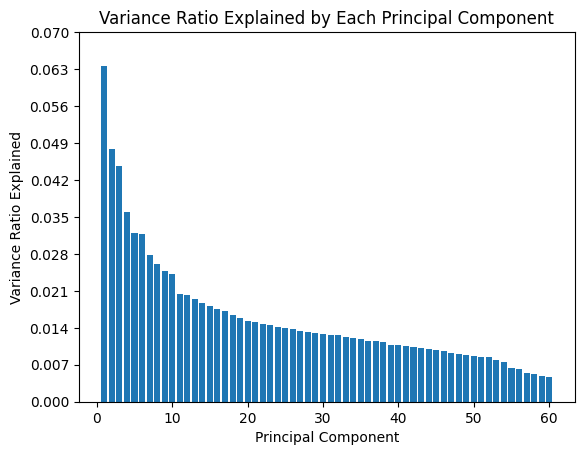

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 925us/step - loss: 0.3763 - accuracy: 0.8502
Epoch 2/40
600/600 [==============================] - 0s 830us/step - loss: 0.3379 - accuracy: 0.8643
Epoch 3/40
600/600 [==============================] - 1s 843us/step - loss: 0.3285 - accuracy: 0.8634
Epoch 4/40
600/600 [==============================] - 1s 892us/step - loss: 0.3203 - accuracy: 0.8626
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3167 - accuracy: 0.8665
Epoch 6/40
600/600 [==============================] - 1s 893us/step - loss: 0.3146 - accuracy: 0.8666
Epoch 7/40
600/600 [==============================] - 1s 890us/step - loss: 0.3106 - accuracy: 0.8684
Epoch 8/40
600/600 [==============================] - 1s 877us/step - loss: 0.3122 - accuracy: 0.8677
Epoch 9/40
600/600 [==============================] - 1s 885us/step - loss: 0.3083 - accuracy: 0.8707
Epoch 10/40
600

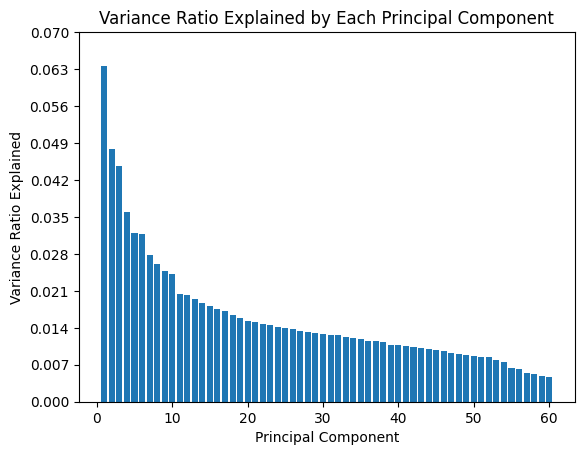

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 923us/step - loss: 0.3719 - accuracy: 0.8518
Epoch 2/40
600/600 [==============================] - 1s 898us/step - loss: 0.3378 - accuracy: 0.8593
Epoch 3/40
600/600 [==============================] - 1s 865us/step - loss: 0.3272 - accuracy: 0.8642
Epoch 4/40
600/600 [==============================] - 1s 890us/step - loss: 0.3241 - accuracy: 0.8662
Epoch 5/40
600/600 [==============================] - 1s 899us/step - loss: 0.3212 - accuracy: 0.8657
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3177 - accuracy: 0.8672
Epoch 7/40
600/600 [==============================] - 1s 885us/step - loss: 0.3181 - accuracy: 0.8671
Epoch 8/40
600/600 [==============================] - 1s 898us/step - loss: 0.3165 - accuracy: 0.8682
Epoch 9/40
600/600 [==============================] - 1s 931us/step - loss: 0.3070 - accuracy: 0.8723
Epoch 10/40
600

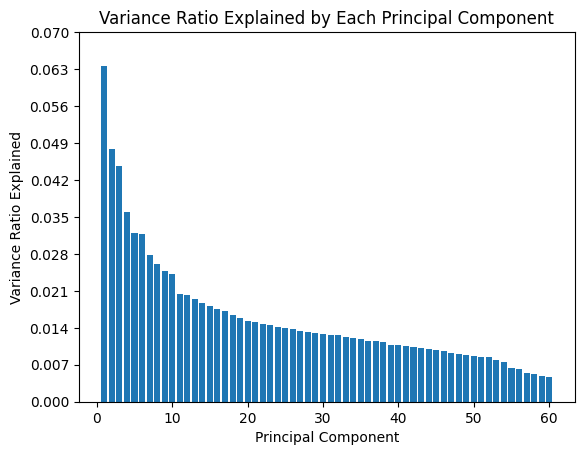

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 944us/step - loss: 0.3694 - accuracy: 0.8566
Epoch 2/40
600/600 [==============================] - 1s 880us/step - loss: 0.3376 - accuracy: 0.8619
Epoch 3/40
600/600 [==============================] - 1s 884us/step - loss: 0.3267 - accuracy: 0.8635
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3247 - accuracy: 0.8666
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3192 - accuracy: 0.8625
Epoch 6/40
600/600 [==============================] - 1s 878us/step - loss: 0.3203 - accuracy: 0.8616
Epoch 7/40
600/600 [==============================] - 1s 916us/step - loss: 0.3172 - accuracy: 0.8681
Epoch 8/40
600/600 [==============================] - 1s 888us/step - loss: 0.3140 - accuracy: 0.8662
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3118 - accuracy: 0.8680
Epoch 10/40
600/600

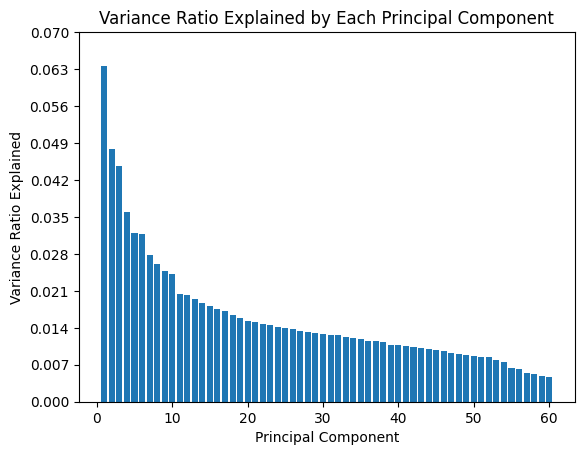

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 924us/step - loss: 0.3718 - accuracy: 0.8533
Epoch 2/40
600/600 [==============================] - 1s 948us/step - loss: 0.3332 - accuracy: 0.8589
Epoch 3/40
600/600 [==============================] - 1s 937us/step - loss: 0.3284 - accuracy: 0.8654
Epoch 4/40
600/600 [==============================] - 1s 872us/step - loss: 0.3222 - accuracy: 0.8637
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3145 - accuracy: 0.8690
Epoch 6/40
600/600 [==============================] - 1s 888us/step - loss: 0.3162 - accuracy: 0.8674
Epoch 7/40
600/600 [==============================] - 1s 851us/step - loss: 0.3083 - accuracy: 0.8725
Epoch 8/40
600/600 [==============================] - 1s 856us/step - loss: 0.3093 - accuracy: 0.8704
Epoch 9/40
600/600 [==============================] - 1s 868us/step - loss: 0.3105 - accuracy: 0.8706
Epoch 10/40
600

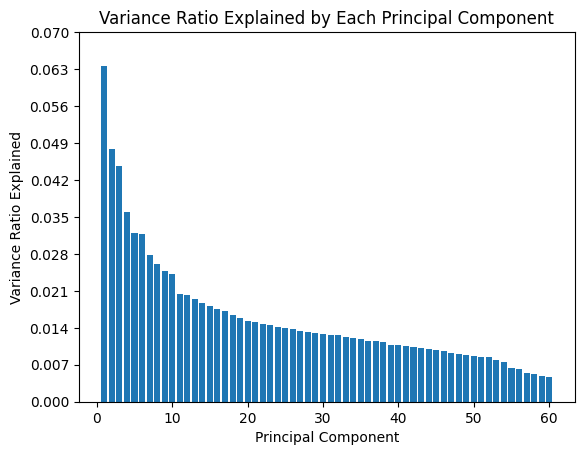

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3673 - accuracy: 0.8537
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3337 - accuracy: 0.8621
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3292 - accuracy: 0.8612
Epoch 4/40
600/600 [==============================] - 1s 955us/step - loss: 0.3229 - accuracy: 0.8653
Epoch 5/40
600/600 [==============================] - 1s 917us/step - loss: 0.3228 - accuracy: 0.8607
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3174 - accuracy: 0.8675
Epoch 7/40
600/600 [==============================] - 1s 884us/step - loss: 0.3207 - accuracy: 0.8637
Epoch 8/40
600/600 [==============================] - 1s 910us/step - loss: 0.3122 - accuracy: 0.8678
Epoch 9/40
600/600 [==============================] - 1s 922us/step - loss: 0.3123 - accuracy: 0.8686
Epoch 10/40
600/600 [

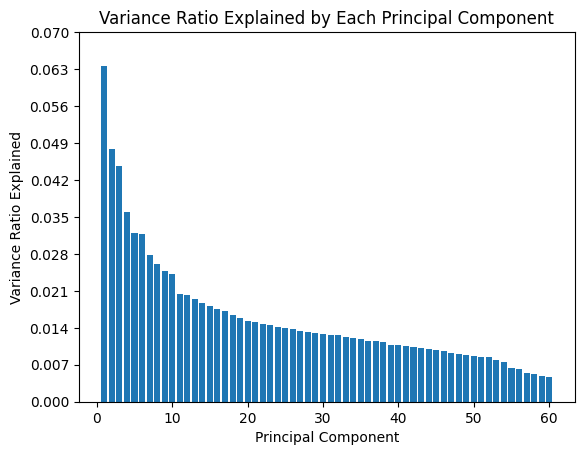

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 925us/step - loss: 0.3678 - accuracy: 0.8542
Epoch 2/40
600/600 [==============================] - 1s 941us/step - loss: 0.3336 - accuracy: 0.8617
Epoch 3/40
600/600 [==============================] - 1s 872us/step - loss: 0.3228 - accuracy: 0.8625
Epoch 4/40
600/600 [==============================] - 1s 880us/step - loss: 0.3200 - accuracy: 0.8672
Epoch 5/40
600/600 [==============================] - 1s 925us/step - loss: 0.3146 - accuracy: 0.8670
Epoch 6/40
600/600 [==============================] - 1s 918us/step - loss: 0.3184 - accuracy: 0.8648
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3124 - accuracy: 0.8691
Epoch 8/40
600/600 [==============================] - 1s 949us/step - loss: 0.3093 - accuracy: 0.8694
Epoch 9/40
600/600 [==============================] - 1s 983us/step - loss: 0.3091 - accuracy: 0.8660
Epoch 10/40
600

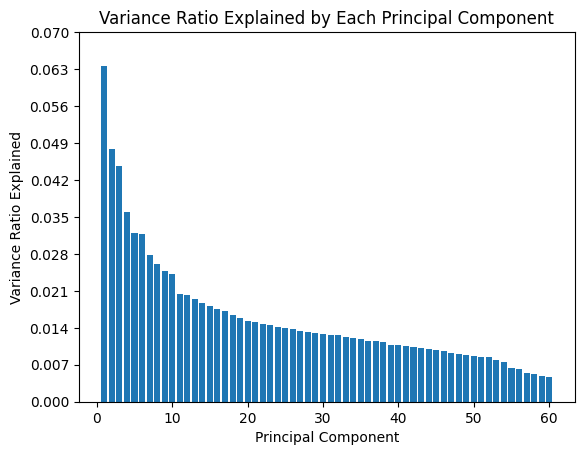

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 927us/step - loss: 0.3688 - accuracy: 0.8531
Epoch 2/40
600/600 [==============================] - 1s 967us/step - loss: 0.3330 - accuracy: 0.8634
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.8642
Epoch 4/40
600/600 [==============================] - 1s 910us/step - loss: 0.3220 - accuracy: 0.8647
Epoch 5/40
600/600 [==============================] - 1s 946us/step - loss: 0.3178 - accuracy: 0.8674
Epoch 6/40
600/600 [==============================] - 1s 969us/step - loss: 0.3109 - accuracy: 0.8699
Epoch 7/40
600/600 [==============================] - 1s 908us/step - loss: 0.3134 - accuracy: 0.8700
Epoch 8/40
600/600 [==============================] - 1s 928us/step - loss: 0.3075 - accuracy: 0.8685
Epoch 9/40
600/600 [==============================] - 1s 947us/step - loss: 0.3096 - accuracy: 0.8698
Epoch 10/40
600

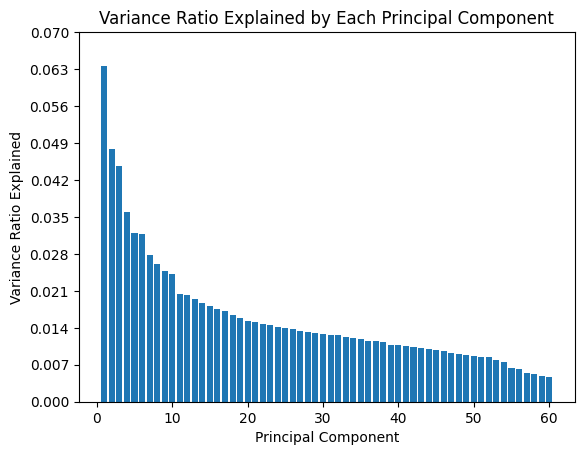

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 930us/step - loss: 0.3762 - accuracy: 0.8543
Epoch 2/40
600/600 [==============================] - 1s 925us/step - loss: 0.3375 - accuracy: 0.8595
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3263 - accuracy: 0.8628
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3187 - accuracy: 0.8664
Epoch 5/40
600/600 [==============================] - 1s 975us/step - loss: 0.3171 - accuracy: 0.8666
Epoch 6/40
600/600 [==============================] - 1s 888us/step - loss: 0.3130 - accuracy: 0.8691
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3105 - accuracy: 0.8662
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3107 - accuracy: 0.8677
Epoch 9/40
600/600 [==============================] - 1s 955us/step - loss: 0.3081 - accuracy: 0.8678
Epoch 10/40
600/600 [

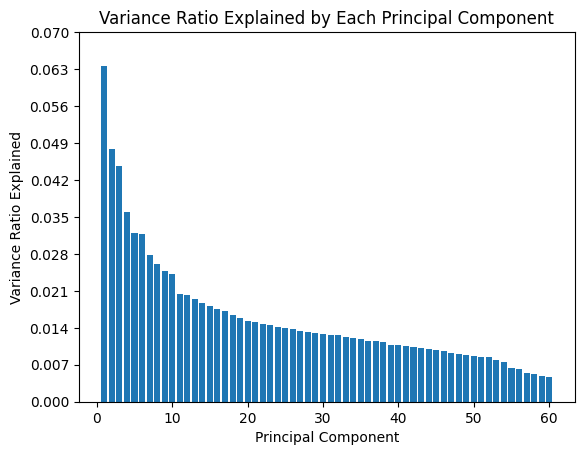

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 930us/step - loss: 0.3688 - accuracy: 0.8544
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3356 - accuracy: 0.8617
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3234 - accuracy: 0.8617
Epoch 4/40
600/600 [==============================] - 1s 981us/step - loss: 0.3217 - accuracy: 0.8622
Epoch 5/40
600/600 [==============================] - 1s 946us/step - loss: 0.3169 - accuracy: 0.8659
Epoch 6/40
600/600 [==============================] - 1s 956us/step - loss: 0.3129 - accuracy: 0.8675
Epoch 7/40
600/600 [==============================] - 1s 931us/step - loss: 0.3148 - accuracy: 0.8661
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3094 - accuracy: 0.8702
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3064 - accuracy: 0.8682
Epoch 10/40
600/600 [

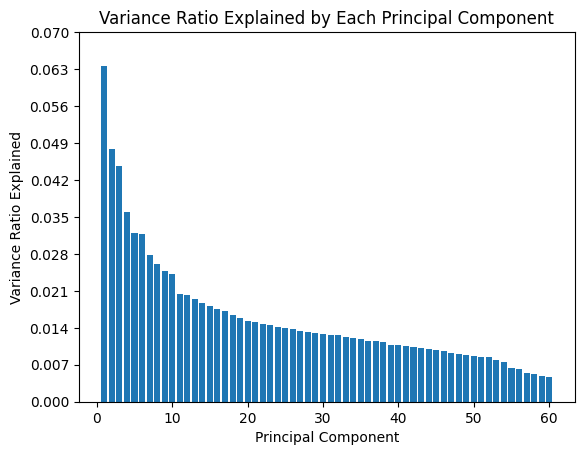

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 943us/step - loss: 0.3694 - accuracy: 0.8561
Epoch 2/40
600/600 [==============================] - 1s 935us/step - loss: 0.3328 - accuracy: 0.8637
Epoch 3/40
600/600 [==============================] - 1s 910us/step - loss: 0.3256 - accuracy: 0.8646
Epoch 4/40
600/600 [==============================] - 1s 932us/step - loss: 0.3229 - accuracy: 0.8668
Epoch 5/40
600/600 [==============================] - 1s 872us/step - loss: 0.3169 - accuracy: 0.8689
Epoch 6/40
600/600 [==============================] - 1s 871us/step - loss: 0.3180 - accuracy: 0.8683
Epoch 7/40
600/600 [==============================] - 1s 868us/step - loss: 0.3111 - accuracy: 0.8694
Epoch 8/40
600/600 [==============================] - 1s 878us/step - loss: 0.3078 - accuracy: 0.8691
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3080 - accuracy: 0.8692
Epoch 10/40
600

In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df,NN_PCA_opt_model)

In [ ]:
print(f"basic_NN_PCA for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "PCA_knn_df"
df_opt_results.loc[2] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_PCA for knn_df : mean_prec = 0.5674022698584693, mean_rec =  0.2794561933534743, stdev_prec = 0.03599959786871625, stdev_recall = 0.0429863823002304


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986


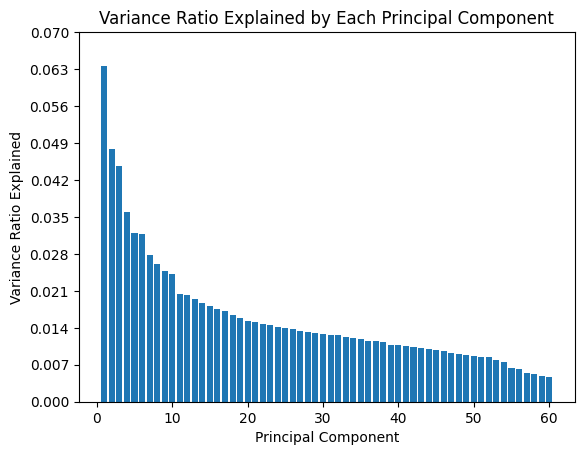

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 855us/step - loss: 0.3674 - accuracy: 0.8540
Epoch 2/40
600/600 [==============================] - 0s 822us/step - loss: 0.3310 - accuracy: 0.8640
Epoch 3/40
600/600 [==============================] - 1s 833us/step - loss: 0.3265 - accuracy: 0.8654
Epoch 4/40
600/600 [==============================] - 1s 832us/step - loss: 0.3220 - accuracy: 0.8628
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3186 - accuracy: 0.8674
Epoch 6/40
600/600 [==============================] - 1s 847us/step - loss: 0.3146 - accuracy: 0.8695
Epoch 7/40
600/600 [==============================] - 1s 907us/step - loss: 0.3129 - accuracy: 0.8714
Epoch 8/40
600/600 [==============================] - 1s 953us/step - loss: 0.3116 - accuracy: 0.8672
Epoch 9/40
600/600 [==============================] - 1s 910us/step - loss: 0.3062 - accuracy: 0.8717
Epoch 10/40
600

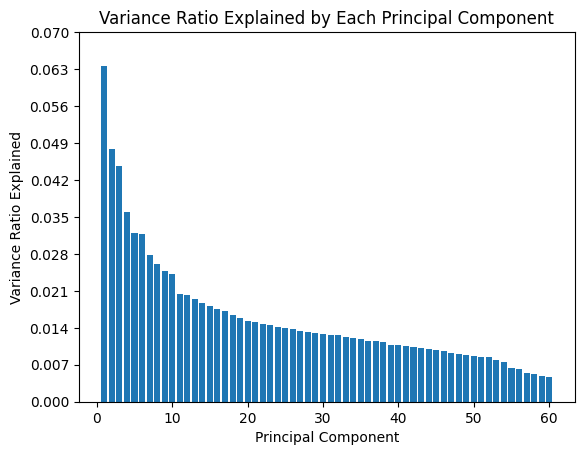

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 939us/step - loss: 0.3705 - accuracy: 0.8550
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3378 - accuracy: 0.8590
Epoch 3/40
600/600 [==============================] - 1s 914us/step - loss: 0.3231 - accuracy: 0.8628
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3179 - accuracy: 0.8646
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3183 - accuracy: 0.8639
Epoch 6/40
600/600 [==============================] - 1s 910us/step - loss: 0.3103 - accuracy: 0.8666
Epoch 7/40
600/600 [==============================] - 1s 907us/step - loss: 0.3108 - accuracy: 0.8647
Epoch 8/40
600/600 [==============================] - 1s 948us/step - loss: 0.3078 - accuracy: 0.8691
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3076 - accuracy: 0.8696
Epoch 10/40
600/600 [

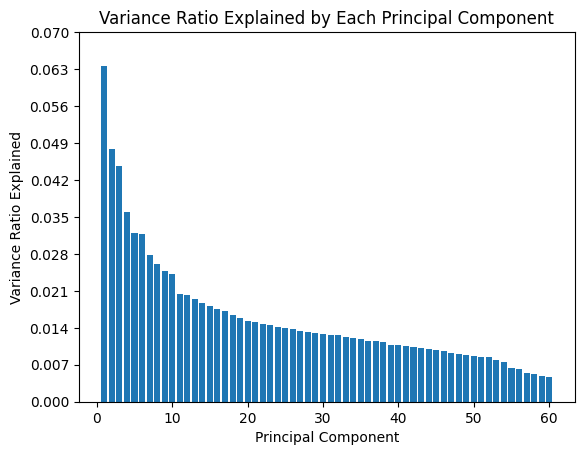

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3718 - accuracy: 0.8534
Epoch 2/40
600/600 [==============================] - 1s 932us/step - loss: 0.3325 - accuracy: 0.8620
Epoch 3/40
600/600 [==============================] - 1s 949us/step - loss: 0.3251 - accuracy: 0.8659
Epoch 4/40
600/600 [==============================] - 1s 905us/step - loss: 0.3183 - accuracy: 0.8675
Epoch 5/40
600/600 [==============================] - 1s 991us/step - loss: 0.3169 - accuracy: 0.8659
Epoch 6/40
600/600 [==============================] - 1s 931us/step - loss: 0.3145 - accuracy: 0.8675
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3143 - accuracy: 0.8630
Epoch 8/40
600/600 [==============================] - 1s 954us/step - loss: 0.3134 - accuracy: 0.8670
Epoch 9/40
600/600 [==============================] - 1s 903us/step - loss: 0.3073 - accuracy: 0.8686
Epoch 10/40
600/6

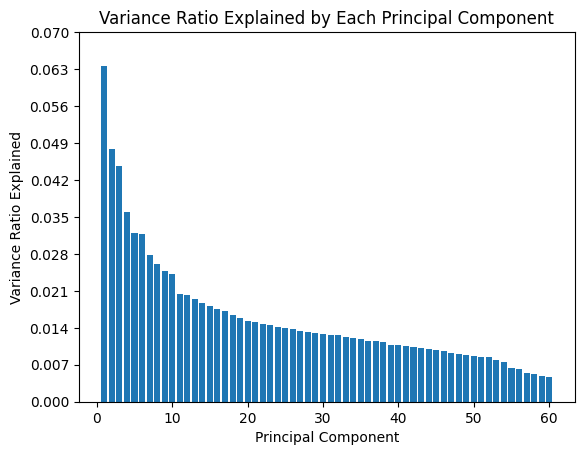

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 926us/step - loss: 0.3726 - accuracy: 0.8533
Epoch 2/40
600/600 [==============================] - 1s 855us/step - loss: 0.3371 - accuracy: 0.8597
Epoch 3/40
600/600 [==============================] - 1s 955us/step - loss: 0.3277 - accuracy: 0.8627
Epoch 4/40
600/600 [==============================] - 1s 843us/step - loss: 0.3221 - accuracy: 0.8627
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3175 - accuracy: 0.8694
Epoch 6/40
600/600 [==============================] - 0s 825us/step - loss: 0.3177 - accuracy: 0.8661
Epoch 7/40
600/600 [==============================] - 0s 813us/step - loss: 0.3149 - accuracy: 0.8653
Epoch 8/40
600/600 [==============================] - 0s 803us/step - loss: 0.3088 - accuracy: 0.8716
Epoch 9/40
600/600 [==============================] - 1s 896us/step - loss: 0.3128 - accuracy: 0.8700
Epoch 10/40
600

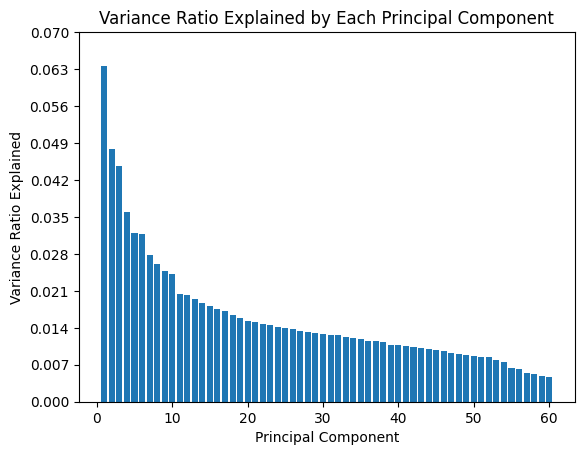

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 820us/step - loss: 0.3654 - accuracy: 0.8546
Epoch 2/40
600/600 [==============================] - 0s 818us/step - loss: 0.3320 - accuracy: 0.8615
Epoch 3/40
600/600 [==============================] - 0s 798us/step - loss: 0.3252 - accuracy: 0.8665
Epoch 4/40
600/600 [==============================] - 0s 828us/step - loss: 0.3208 - accuracy: 0.8669
Epoch 5/40
600/600 [==============================] - 0s 828us/step - loss: 0.3200 - accuracy: 0.8665
Epoch 6/40
600/600 [==============================] - 1s 838us/step - loss: 0.3178 - accuracy: 0.8653
Epoch 7/40
600/600 [==============================] - 0s 799us/step - loss: 0.3144 - accuracy: 0.8666
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3099 - accuracy: 0.8665
Epoch 9/40
600/600 [==============================] - 0s 824us/step - loss: 0.3092 - accuracy: 0.8693
Epoch 10/40
600

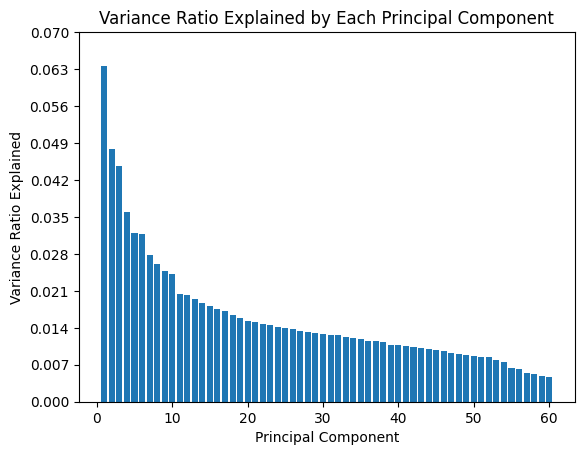

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 912us/step - loss: 0.3711 - accuracy: 0.8537
Epoch 2/40
600/600 [==============================] - 0s 810us/step - loss: 0.3397 - accuracy: 0.8606
Epoch 3/40
600/600 [==============================] - 1s 880us/step - loss: 0.3289 - accuracy: 0.8610
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3229 - accuracy: 0.8642
Epoch 5/40
600/600 [==============================] - 1s 942us/step - loss: 0.3209 - accuracy: 0.8650
Epoch 6/40
600/600 [==============================] - 0s 823us/step - loss: 0.3141 - accuracy: 0.8670
Epoch 7/40
600/600 [==============================] - 1s 856us/step - loss: 0.3114 - accuracy: 0.8643
Epoch 8/40
600/600 [==============================] - 1s 834us/step - loss: 0.3105 - accuracy: 0.8676
Epoch 9/40
600/600 [==============================] - 1s 897us/step - loss: 0.3090 - accuracy: 0.8714
Epoch 10/40
600

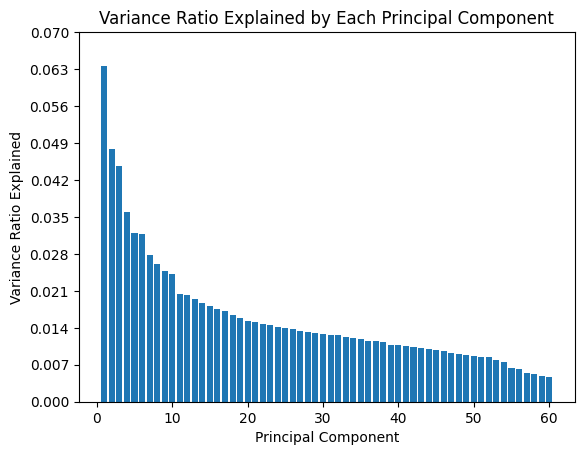

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 871us/step - loss: 0.3666 - accuracy: 0.8547
Epoch 2/40
600/600 [==============================] - 1s 912us/step - loss: 0.3313 - accuracy: 0.8662
Epoch 3/40
600/600 [==============================] - 1s 903us/step - loss: 0.3239 - accuracy: 0.8649
Epoch 4/40
600/600 [==============================] - 1s 917us/step - loss: 0.3200 - accuracy: 0.8667
Epoch 5/40
600/600 [==============================] - 1s 863us/step - loss: 0.3159 - accuracy: 0.8676
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3100 - accuracy: 0.8720
Epoch 7/40
600/600 [==============================] - 0s 815us/step - loss: 0.3120 - accuracy: 0.8675
Epoch 8/40
600/600 [==============================] - 0s 817us/step - loss: 0.3106 - accuracy: 0.8700
Epoch 9/40
600/600 [==============================] - 1s 838us/step - loss: 0.3092 - accuracy: 0.8716
Epoch 10/40
600

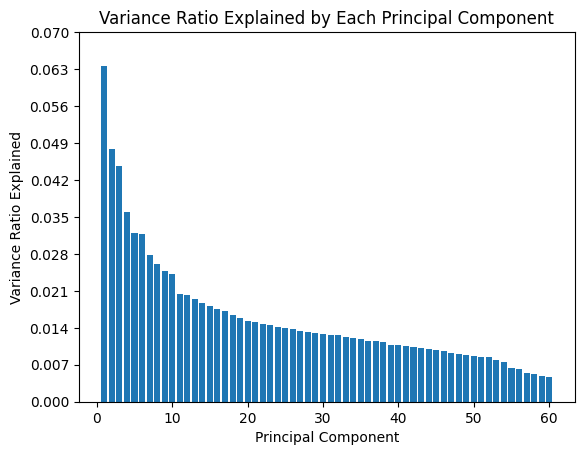

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 888us/step - loss: 0.3755 - accuracy: 0.8548
Epoch 2/40
600/600 [==============================] - 0s 803us/step - loss: 0.3336 - accuracy: 0.8647
Epoch 3/40
600/600 [==============================] - 1s 997us/step - loss: 0.3299 - accuracy: 0.8645
Epoch 4/40
600/600 [==============================] - 1s 895us/step - loss: 0.3252 - accuracy: 0.8634
Epoch 5/40
600/600 [==============================] - 1s 882us/step - loss: 0.3174 - accuracy: 0.8655
Epoch 6/40
600/600 [==============================] - 0s 825us/step - loss: 0.3152 - accuracy: 0.8683
Epoch 7/40
600/600 [==============================] - 0s 812us/step - loss: 0.3133 - accuracy: 0.8652
Epoch 8/40
600/600 [==============================] - 1s 896us/step - loss: 0.3133 - accuracy: 0.8667
Epoch 9/40
600/600 [==============================] - 1s 843us/step - loss: 0.3060 - accuracy: 0.8666
Epoch 10/40
6

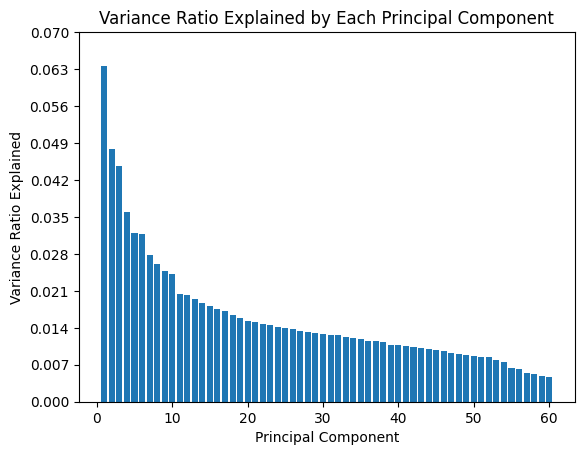

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 883us/step - loss: 0.3730 - accuracy: 0.8549
Epoch 2/40
600/600 [==============================] - 1s 898us/step - loss: 0.3367 - accuracy: 0.8609
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3239 - accuracy: 0.8645
Epoch 4/40
600/600 [==============================] - 1s 966us/step - loss: 0.3188 - accuracy: 0.8667
Epoch 5/40
600/600 [==============================] - 1s 845us/step - loss: 0.3167 - accuracy: 0.8651
Epoch 6/40
600/600 [==============================] - 1s 840us/step - loss: 0.3136 - accuracy: 0.8690
Epoch 7/40
600/600 [==============================] - 1s 852us/step - loss: 0.3114 - accuracy: 0.8712
Epoch 8/40
600/600 [==============================] - 0s 813us/step - loss: 0.3085 - accuracy: 0.8720
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3031 - accuracy: 0.8729
Epoch 10/40
600/6

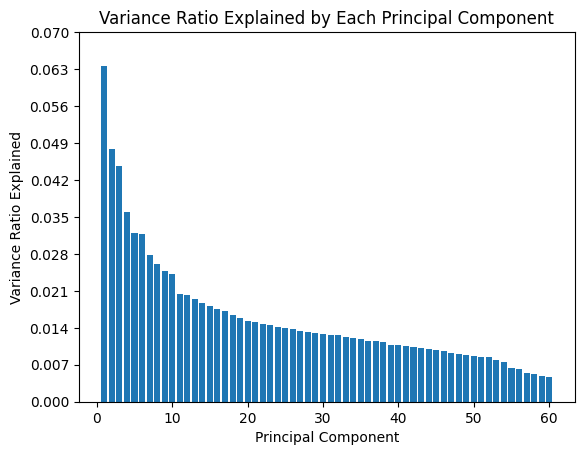

Number of components required to achieve 0.95 variance explained: 60
Epoch 1/40
600/600 [==============================] - 1s 877us/step - loss: 0.3751 - accuracy: 0.8546
Epoch 2/40
600/600 [==============================] - 1s 930us/step - loss: 0.3362 - accuracy: 0.8619
Epoch 3/40
600/600 [==============================] - 0s 815us/step - loss: 0.3264 - accuracy: 0.8620
Epoch 4/40
600/600 [==============================] - 0s 831us/step - loss: 0.3212 - accuracy: 0.8647
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3175 - accuracy: 0.8675
Epoch 6/40
600/600 [==============================] - 1s 913us/step - loss: 0.3172 - accuracy: 0.8672
Epoch 7/40
600/600 [==============================] - 1s 875us/step - loss: 0.3123 - accuracy: 0.8679
Epoch 8/40
600/600 [==============================] - 1s 919us/step - loss: 0.3105 - accuracy: 0.8694
Epoch 9/40
600/600 [==============================] - 1s 938us/step - loss: 0.3123 - accuracy: 0.8651
Epoch 10/40
600

In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df,NN_PCA_opt_model)

In [ ]:
print(f"basic_NN_PCA for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "PCA_m1_df"
df_opt_results.loc[3] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_PCA for m1_df : mean_prec = 0.5637123757968887, mean_rec =  0.3051359516616315, stdev_prec = 0.033598417239816256, stdev_recall = 0.05848867693210906


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986
3,NN_opt,PCA_m1_df,0.563712,0.305136,0.033598,0.058489


**3.4 -Managing the inbalance problem.**

Balancing the initial dataframes with two different methods:

 - SOMTE
 - RandomOverSampler

In [ ]:
def NN_Balanced_opt_model(df, method):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data balancing
    met = method(random_state=42)
    X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

 # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return  y_test,y_pred_binary

as now we are using a function (NN_Balanced_model) that requiers an extra argument from run_10_times function we must use a labmda function to be able to pass this extra argument.

In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_opt_model(knn_df, method=SMOTE))

Epoch 1/40
1028/1028 [==============================] - 1s 927us/step - loss: 0.5097 - accuracy: 0.7559
Epoch 2/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4538 - accuracy: 0.7921
Epoch 3/40
1028/1028 [==============================] - 1s 926us/step - loss: 0.4356 - accuracy: 0.8048
Epoch 4/40
1028/1028 [==============================] - 1s 925us/step - loss: 0.4256 - accuracy: 0.8112
Epoch 5/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4103 - accuracy: 0.8171
Epoch 6/40
1028/1028 [==============================] - 1s 949us/step - loss: 0.4090 - accuracy: 0.8217
Epoch 7/40
1028/1028 [==============================] - 1s 923us/step - loss: 0.3986 - accuracy: 0.8273
Epoch 8/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.3997 - accuracy: 0.8231
Epoch 9/40
1028/1028 [==============================] - 1s 943us/step - loss: 0.3864 - accuracy: 0.8329
Epoch 10/40
1028/1028 [==============================] - 1s 905us/step

In [ ]:
print(f"basic_NN_smote for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "Smote_knn_df"
df_opt_results.loc[4] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_smote for knn_df : mean_prec = 0.34556678219543274, mean_rec =  0.5722054380664653, stdev_prec = 0.018859354554907018, stdev_recall = 0.03500362140896734


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986
3,NN_opt,PCA_m1_df,0.563712,0.305136,0.033598,0.058489
4,NN_opt,Smote_knn_df,0.345567,0.572205,0.018859,0.035004


In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_opt_model(m1_df, method=SMOTE))

Epoch 1/40
1028/1028 [==============================] - 1s 948us/step - loss: 0.5210 - accuracy: 0.7433
Epoch 2/40
1028/1028 [==============================] - 1s 872us/step - loss: 0.4686 - accuracy: 0.7849
Epoch 3/40
1028/1028 [==============================] - 1s 862us/step - loss: 0.4505 - accuracy: 0.7923
Epoch 4/40
1028/1028 [==============================] - 1s 880us/step - loss: 0.4344 - accuracy: 0.8028
Epoch 5/40
1028/1028 [==============================] - 1s 977us/step - loss: 0.4238 - accuracy: 0.8135
Epoch 6/40
1028/1028 [==============================] - 1s 873us/step - loss: 0.4163 - accuracy: 0.8127
Epoch 7/40
1028/1028 [==============================] - 1s 880us/step - loss: 0.4139 - accuracy: 0.8179
Epoch 8/40
1028/1028 [==============================] - 1s 874us/step - loss: 0.4064 - accuracy: 0.8184
Epoch 9/40
1028/1028 [==============================] - 1s 867us/step - loss: 0.4010 - accuracy: 0.8221
Epoch 10/40
1028/1028 [==============================] - 1s 985u

In [ ]:
print(f"basic_NN_smote for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "Smote_m1_df"
df_opt_results.loc[5] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_smote for m1_df : mean_prec = 0.3422332729777094, mean_rec =  0.5510574018126888, stdev_prec = 0.014113253254764745, stdev_recall = 0.023680867603946137


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986
3,NN_opt,PCA_m1_df,0.563712,0.305136,0.033598,0.058489
4,NN_opt,Smote_knn_df,0.345567,0.572205,0.018859,0.035004
5,NN_opt,Smote_m1_df,0.342233,0.551057,0.014113,0.023681


In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(knn_df, lambda method: NN_Balanced_opt_model(knn_df, method=RandomOverSampler))

Epoch 1/40
1028/1028 [==============================] - 1s 876us/step - loss: 0.5449 - accuracy: 0.7250
Epoch 2/40
1028/1028 [==============================] - 1s 859us/step - loss: 0.4911 - accuracy: 0.7670
Epoch 3/40
1028/1028 [==============================] - 1s 865us/step - loss: 0.4774 - accuracy: 0.7781
Epoch 4/40
1028/1028 [==============================] - 1s 976us/step - loss: 0.4653 - accuracy: 0.7844
Epoch 5/40
1028/1028 [==============================] - 1s 867us/step - loss: 0.4498 - accuracy: 0.7920
Epoch 6/40
1028/1028 [==============================] - 1s 873us/step - loss: 0.4459 - accuracy: 0.7960
Epoch 7/40
1028/1028 [==============================] - 1s 862us/step - loss: 0.4427 - accuracy: 0.7978
Epoch 8/40
1028/1028 [==============================] - 1s 957us/step - loss: 0.4314 - accuracy: 0.8002
Epoch 9/40
1028/1028 [==============================] - 1s 919us/step - loss: 0.4290 - accuracy: 0.8047
Epoch 10/40
1028/1028 [==============================] - 1s 857u

In [ ]:
print(f"basic_NN_ros for knn_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "ros_knn_df"
df_opt_results.loc[6] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_ros for knn_df : mean_prec = 0.3464612844988636, mean_rec =  0.6809667673716011, stdev_prec = 0.020461806770603125, stdev_recall = 0.03285142530288386


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986
3,NN_opt,PCA_m1_df,0.563712,0.305136,0.033598,0.058489
4,NN_opt,Smote_knn_df,0.345567,0.572205,0.018859,0.035004
5,NN_opt,Smote_m1_df,0.342233,0.551057,0.014113,0.023681
6,NN_opt,ros_knn_df,0.346461,0.680967,0.020462,0.032851


In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_Balanced_opt_model(m1_df, method=RandomOverSampler))

Epoch 1/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.5559 - accuracy: 0.7219
Epoch 2/40
1028/1028 [==============================] - 1s 898us/step - loss: 0.5045 - accuracy: 0.7546
Epoch 3/40
1028/1028 [==============================] - 1s 979us/step - loss: 0.4893 - accuracy: 0.7698
Epoch 4/40
1028/1028 [==============================] - 1s 975us/step - loss: 0.4810 - accuracy: 0.7720
Epoch 5/40
1028/1028 [==============================] - 1s 929us/step - loss: 0.4690 - accuracy: 0.7812
Epoch 6/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4609 - accuracy: 0.7805
Epoch 7/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4523 - accuracy: 0.7907
Epoch 8/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4500 - accuracy: 0.7896
Epoch 9/40
1028/1028 [==============================] - 1s 1ms/step - loss: 0.4474 - accuracy: 0.7963
Epoch 10/40
1028/1028 [==============================] - 1s 896us/step - l

In [ ]:
print(f"basic_NN_ros for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")
#introducing the results in the df_results
Model = 'NN_opt'
method_name = "ros_m1_df"
df_opt_results.loc[7] = [Model,method_name, mean_prec, mean_rec, stdev_prec, stdev_recall]
df_opt_results

basic_NN_ros for m1_df : mean_prec = 0.3504584299218615, mean_rec =  0.6667673716012085, stdev_prec = 0.021643885168481532, stdev_recall = 0.04707662182341112


,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986
3,NN_opt,PCA_m1_df,0.563712,0.305136,0.033598,0.058489
4,NN_opt,Smote_knn_df,0.345567,0.572205,0.018859,0.035004
5,NN_opt,Smote_m1_df,0.342233,0.551057,0.014113,0.023681
6,NN_opt,ros_knn_df,0.346461,0.680967,0.020462,0.032851
7,NN_opt,ros_m1_df,0.350458,0.666767,0.021644,0.047077


In [ ]:
df_opt_results_12000= df_opt_results

In [ ]:
df_opt_results_12000

,Model,Method,mean_precision,mean_recall,stdev_precision,stdev_recall
0,NN_opt,knn_df,0.560504,0.308157,0.027549,0.051377
1,NN_opt,m1_df,0.538745,0.342900,0.028827,0.057135
2,NN_opt,PCA_knn_df,0.567402,0.279456,0.036000,0.042986
3,NN_opt,PCA_m1_df,0.563712,0.305136,0.033598,0.058489
4,NN_opt,Smote_knn_df,0.345567,0.572205,0.018859,0.035004
5,NN_opt,Smote_m1_df,0.342233,0.551057,0.014113,0.023681
6,NN_opt,ros_knn_df,0.346461,0.680967,0.020462,0.032851
7,NN_opt,ros_m1_df,0.350458,0.666767,0.021644,0.047077


drop_rate = 0.3 (prec, rec = 0.350458	0.666767)
drop_rate = 0.7 (mean_prec = 0.30602538008276087, mean_rec =  0.7652567975830815, stdev_prec = 0.009188872319283711, stdev_recall = 0.03326145412843714)
Sin Dropout = mean_prec = 0.3338162698979897, mean_rec =  0.5271903323262841, stdev_prec = 0.014497970006701203, stdev_recall = 0.032461529207756655
drop_rate = 0.02 (mean_prec = 0.31968088869284467, mean_rec =  0.566465256797583, stdev_prec = 0.017300757192120517, stdev_recall = 0.048587913270099536)

ros_m1_std_loss = 0.350458	0.666767	0.021644	0.047077
ros_m1_weithed_loss = mean_prec = 0.3517653745689407, mean_rec =  0.6697885196374622, stdev_prec = 0.020793514629840998, stdev_recall = 0.02978704885971562

In [ ]:
def NN_test_model(df, method):
    """
    Builds and trains an improved neural network model for binary classification with previous balanced strategy of the df.

    Args:
        Data frame.
        Method: balancing method to be applied to the Data frame

    Returns:
        Predicted value and real test value.
    """
    # Extract features and target variable
    X = df.drop(columns=['In-hospital_death', 'Length_of_stay'])
    y = df['In-hospital_death']

    # Data splitting
    test_size = 0.2
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Data balancing
    #met = method(random_state=42)
    #X_train, y_train = met.fit_resample(X_train, y_train)

    # Data normalization
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

 # Model architecture with BatchNormalization and Dropout
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))  # Add dropout layer
    model.add(Dense(28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer and compilation
    sgd = SGD(learning_rate=0.1)
    model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=sgd, metrics=["accuracy"])

    # Model training
    epochs = 40
    batch_size = 16
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    print(f"Precision on test set: {precision:.2f}")
    print(f"Recall on test set: {recall:.2f}")

    return  y_test,y_pred_binary

In [ ]:
mean_prec, mean_rec, stdev_prec, stdev_recall = run_function_10_times(m1_df, lambda method: NN_test_model(m1_df, method=RandomOverSampler))

Epoch 1/40


c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 925us/step - loss: 0.3730 - accuracy: 0.8521
Epoch 2/40
600/600 [==============================] - 1s 935us/step - loss: 0.3405 - accuracy: 0.8599
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3300 - accuracy: 0.8594
Epoch 4/40
600/600 [==============================] - 1s 887us/step - loss: 0.3267 - accuracy: 0.8631
Epoch 5/40
600/600 [==============================] - 1s 839us/step - loss: 0.3202 - accuracy: 0.8659
Epoch 6/40
600/600 [==============================] - 1s 871us/step - loss: 0.3193 - accuracy: 0.8648
Epoch 7/40
600/600 [==============================] - 1s 865us/step - loss: 0.3124 - accuracy: 0.8684
Epoch 8/40
600/600 [==============================] - 1s 866us/step - loss: 0.3134 - accuracy: 0.8700
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3096 - accuracy: 0.8692
Epoch 10/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3055 - accuracy: 0.8

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 944us/step - loss: 0.3813 - accuracy: 0.8509
Epoch 2/40
600/600 [==============================] - 1s 928us/step - loss: 0.3419 - accuracy: 0.8593
Epoch 3/40
600/600 [==============================] - 1s 943us/step - loss: 0.3342 - accuracy: 0.8616
Epoch 4/40
600/600 [==============================] - 1s 897us/step - loss: 0.3290 - accuracy: 0.8620
Epoch 5/40
600/600 [==============================] - 1s 956us/step - loss: 0.3188 - accuracy: 0.8615
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3158 - accuracy: 0.8612
Epoch 7/40
600/600 [==============================] - 1s 873us/step - loss: 0.3098 - accuracy: 0.8661
Epoch 8/40
600/600 [==============================] - 1s 866us/step - loss: 0.3139 - accuracy: 0.8680
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3124 - accuracy: 0.8696
Epoch 10/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3070 - accuracy: 0.8

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 942us/step - loss: 0.3776 - accuracy: 0.8480
Epoch 2/40
600/600 [==============================] - 1s 920us/step - loss: 0.3400 - accuracy: 0.8568
Epoch 3/40
600/600 [==============================] - 1s 914us/step - loss: 0.3334 - accuracy: 0.8593
Epoch 4/40
600/600 [==============================] - 1s 936us/step - loss: 0.3239 - accuracy: 0.8646
Epoch 5/40
600/600 [==============================] - 1s 913us/step - loss: 0.3275 - accuracy: 0.8626
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3180 - accuracy: 0.8651
Epoch 7/40
600/600 [==============================] - 1s 873us/step - loss: 0.3158 - accuracy: 0.8622
Epoch 8/40
600/600 [==============================] - 1s 862us/step - loss: 0.3125 - accuracy: 0.8647
Epoch 9/40
600/600 [==============================] - 1s 865us/step - loss: 0.3145 - accuracy: 0.8664
Epoch 10/40
600/600 [==============================] - 1s 903us/step - loss: 0.3083 - accuracy:

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 948us/step - loss: 0.3671 - accuracy: 0.8518
Epoch 2/40
600/600 [==============================] - 1s 872us/step - loss: 0.3354 - accuracy: 0.8643
Epoch 3/40
600/600 [==============================] - 1s 873us/step - loss: 0.3278 - accuracy: 0.8618
Epoch 4/40
600/600 [==============================] - 1s 885us/step - loss: 0.3230 - accuracy: 0.8642
Epoch 5/40
600/600 [==============================] - 1s 904us/step - loss: 0.3174 - accuracy: 0.8673
Epoch 6/40
600/600 [==============================] - 1s 888us/step - loss: 0.3163 - accuracy: 0.8651
Epoch 7/40
600/600 [==============================] - 1s 901us/step - loss: 0.3158 - accuracy: 0.8669
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3153 - accuracy: 0.8674
Epoch 9/40
600/600 [==============================] - 1s 846us/step - loss: 0.3124 - accuracy: 0.8665
Epoch 10/40
600/600 [==============================] - 1s 852us/step - loss: 0.3108 - accuracy:

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 920us/step - loss: 0.3755 - accuracy: 0.8520
Epoch 2/40
600/600 [==============================] - 1s 948us/step - loss: 0.3398 - accuracy: 0.8618
Epoch 3/40
600/600 [==============================] - 1s 887us/step - loss: 0.3318 - accuracy: 0.8619
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3252 - accuracy: 0.8634
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3199 - accuracy: 0.8610
Epoch 6/40
600/600 [==============================] - 1s 936us/step - loss: 0.3156 - accuracy: 0.8641
Epoch 7/40
600/600 [==============================] - 1s 981us/step - loss: 0.3114 - accuracy: 0.8654
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3139 - accuracy: 0.8672
Epoch 9/40
600/600 [==============================] - 1s 951us/step - loss: 0.3094 - accuracy: 0.8669
Epoch 10/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3079 - accuracy: 0.869

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 965us/step - loss: 0.3749 - accuracy: 0.8522
Epoch 2/40
600/600 [==============================] - 1s 837us/step - loss: 0.3398 - accuracy: 0.8601
Epoch 3/40
600/600 [==============================] - 1s 922us/step - loss: 0.3277 - accuracy: 0.8641
Epoch 4/40
600/600 [==============================] - 1s 902us/step - loss: 0.3227 - accuracy: 0.8654
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3212 - accuracy: 0.8622
Epoch 6/40
600/600 [==============================] - 1s 851us/step - loss: 0.3189 - accuracy: 0.8656
Epoch 7/40
600/600 [==============================] - 0s 823us/step - loss: 0.3155 - accuracy: 0.8658
Epoch 8/40
600/600 [==============================] - 1s 866us/step - loss: 0.3123 - accuracy: 0.8684
Epoch 9/40
600/600 [==============================] - 0s 821us/step - loss: 0.3109 - accuracy: 0.8678
Epoch 10/40
600/600 [==============================] - 1s 881us/step - loss: 0.3085 - accuracy:

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 968us/step - loss: 0.3751 - accuracy: 0.8545
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3418 - accuracy: 0.8617
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3326 - accuracy: 0.8591
Epoch 4/40
600/600 [==============================] - 1s 840us/step - loss: 0.3246 - accuracy: 0.8631
Epoch 5/40
600/600 [==============================] - 1s 976us/step - loss: 0.3203 - accuracy: 0.8642
Epoch 6/40
600/600 [==============================] - 1s 932us/step - loss: 0.3180 - accuracy: 0.8674
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3172 - accuracy: 0.8646
Epoch 8/40
600/600 [==============================] - 1s 948us/step - loss: 0.3151 - accuracy: 0.8680
Epoch 9/40
600/600 [==============================] - 1s 952us/step - loss: 0.3131 - accuracy: 0.8712
Epoch 10/40
600/600 [==============================] - 1s 919us/step - loss: 0.3072 - accuracy: 0.8

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 910us/step - loss: 0.3697 - accuracy: 0.8531
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3401 - accuracy: 0.8579
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3308 - accuracy: 0.8594
Epoch 4/40
600/600 [==============================] - 1s 905us/step - loss: 0.3303 - accuracy: 0.8609
Epoch 5/40
600/600 [==============================] - 1s 981us/step - loss: 0.3232 - accuracy: 0.8634
Epoch 6/40
600/600 [==============================] - 1s 930us/step - loss: 0.3201 - accuracy: 0.8655
Epoch 7/40
600/600 [==============================] - 1s 947us/step - loss: 0.3174 - accuracy: 0.8653
Epoch 8/40
600/600 [==============================] - 1s 974us/step - loss: 0.3170 - accuracy: 0.8622
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3108 - accuracy: 0.8673
Epoch 10/40
600/600 [==============================] - 1s 972us/step - loss: 0.3088 - accuracy: 0.8

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 965us/step - loss: 0.3726 - accuracy: 0.8530
Epoch 2/40
600/600 [==============================] - 1s 896us/step - loss: 0.3375 - accuracy: 0.8592
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3299 - accuracy: 0.8598
Epoch 4/40
600/600 [==============================] - 1s 861us/step - loss: 0.3262 - accuracy: 0.8649
Epoch 5/40
600/600 [==============================] - 1s 880us/step - loss: 0.3201 - accuracy: 0.8656
Epoch 6/40
600/600 [==============================] - 1s 869us/step - loss: 0.3198 - accuracy: 0.8642
Epoch 7/40
600/600 [==============================] - 1s 852us/step - loss: 0.3150 - accuracy: 0.8677
Epoch 8/40
600/600 [==============================] - 1s 876us/step - loss: 0.3153 - accuracy: 0.8675
Epoch 9/40
600/600 [==============================] - 1s 972us/step - loss: 0.3098 - accuracy: 0.8672
Epoch 10/40
600/600 [==============================] - 1s 834us/step - loss: 0.3113 - accuracy:

c:\Users\psaez\miniconda3\envs\ironhack\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


600/600 [==============================] - 1s 1ms/step - loss: 0.3754 - accuracy: 0.8535
Epoch 2/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3396 - accuracy: 0.8593
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.3292 - accuracy: 0.8628
Epoch 4/40
600/600 [==============================] - 1s 887us/step - loss: 0.3251 - accuracy: 0.8640
Epoch 5/40
600/600 [==============================] - 1s 860us/step - loss: 0.3205 - accuracy: 0.8635
Epoch 6/40
600/600 [==============================] - 1s 885us/step - loss: 0.3194 - accuracy: 0.8648
Epoch 7/40
600/600 [==============================] - 1s 841us/step - loss: 0.3166 - accuracy: 0.8676
Epoch 8/40
600/600 [==============================] - 1s 2ms/step - loss: 0.3104 - accuracy: 0.8702
Epoch 9/40
600/600 [==============================] - 1s 919us/step - loss: 0.3124 - accuracy: 0.8686
Epoch 10/40
600/600 [==============================] - 1s 913us/step - loss: 0.3101 - accuracy: 0.868

- binary croos ent WEIGHTED = Precision on test set: 0.36  Recall on test set: 0.69
- STD = 	NN_opt	ros_m1_df	0.350458	0.666767	
- WEIGHTED + 1 hidden layer + 1 drop layer : Precision on test set: 0.30 Recall on test set: 0.76
- WEITHED + Dropout(0.5) Precision on test set: 0.33  Recall on test set: 0.79
- WEITHED with no Ros : Precision on test set: 0.59  Recall on test set: 0.24


print(f"basic_NN_ros_pca for m1_df : mean_prec = {mean_prec}, mean_rec =  {mean_rec}, stdev_prec = {stdev_prec}, stdev_recall = {stdev_recall}")


In [ ]:
m1_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,...,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
2485,138793.0,79.0,1,2,29.860495,1,17.0,17.647059,0.166134,1.1,...,35.0,-0.935747,12.65,11.067194,-0.0584,86.5,0.0,-1.0,8,0
